In [1]:
import pandas as pd
import csv
import os

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
folder_path = "../Datasets/QUIC"
all_sessions = []
labels = []
for label in os.listdir(folder_path):
    label_folder_path = os.path.join(folder_path, label)
    if os.path.isdir(label_folder_path):
        for filename in os.listdir(label_folder_path):
            file_path = os.path.join(label_folder_path, filename)

            session_df = pd.read_csv(
                file_path,
                sep="\t",
                header=None,
                skiprows=0,
                usecols=[0, 2, 3],
                nrows=100,
            )
            session_df.columns = ["Timestamp", "Packet Size", "Direction"]

            if not session_df.empty:
                all_sessions.append(session_df)
                labels.append(label)

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# Merge all DataFrames to one DataFrame.
all_data = pd.concat(all_sessions, ignore_index=True)
# Normalizing the features to the range (0,1).
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_data[["Packet Size", "Direction"]])

for i in range(len(all_sessions)):
    all_sessions[i][["Packet Size", "Direction"]] = scaler.transform(
        all_sessions[i][["Packet Size", "Direction"]]
    )
# Creating a list of the time series.
sequences = [session[["Packet Size", "Direction"]
                     ].values for session in all_sessions]

sequences_padded = pad_sequences(sequences, dtype="float32")
sequences_padded_2d = sequences_padded.reshape(sequences_padded.shape[0], -1)

labels = np.array(labels)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# compare the perfomance of all classification models on 3-fold startified cross validation
# and perform hyperparameter tuning for each model
models = []
# models.append(("LR", LogisticRegression()))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("SVM", SVC()))
models.append(("RF", RandomForestClassifier()))
models.append(("NB", GaussianNB()))
models.append(("DT", DecisionTreeClassifier()))
# models.append(("XGB", XGBClassifier()))
# models.append(("LGBM", LGBMClassifier()))
# models.append(("CatBoost", CatBoostClassifier()))

In [5]:
# evaluate each model in turn (accuracy, precision, recall and f1-score for each class)
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

results = []
names = []
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    cv_results = cross_validate(
        model, sequences_padded_2d, labels, cv=kfold, scoring=scoring
    )
    clf = model.fit(sequences_padded_2d, labels)
    y_pred = clf.predict(sequences_padded_2d)
    print(name)
    print("Accuracy: ", accuracy_score(labels, y_pred))
    print("Confusion Matrix: \n", confusion_matrix(labels, y_pred))
    print("Classification Report: \n", classification_report(labels, y_pred))
    print("Best Parameters: \n", clf.get_params())
    print("-------------------------------------------------------------------------")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f) %f (%f) %f (%f) %f (%f)" % (
        name,
        cv_results["test_accuracy"].mean(),
        cv_results["test_accuracy"].std(),
        cv_results["test_precision_macro"].mean(),
        cv_results["test_precision_macro"].std(),
        cv_results["test_recall_macro"].mean(),
        cv_results["test_recall_macro"].std(),
        cv_results["test_f1_macro"].mean(),
        cv_results["test_f1_macro"].std(),
    )
    print(msg)
    print("-------------------------------------------------------------------------")

LDA
Accuracy:  0.8551017238701661
Confusion Matrix: 
 [[1082   75    1   57    6]
 [ 174 1199   66   69  126]
 [   1   14  524    2   51]
 [  21   62    0 1828    4]
 [   1   84  119    0  873]]
Classification Report: 
                precision    recall  f1-score   support

   Google Doc       0.85      0.89      0.87      1221
 Google Drive       0.84      0.73      0.78      1634
 Google Music       0.74      0.89      0.80       592
Google Search       0.93      0.95      0.94      1915
      Youtube       0.82      0.81      0.82      1077

     accuracy                           0.86      6439
    macro avg       0.84      0.85      0.84      6439
 weighted avg       0.86      0.86      0.85      6439

Best Parameters: 
 {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
-------------------------------------------------------------------------
LDA: 0.839882 (0.001919) 0.822214 (0.00280

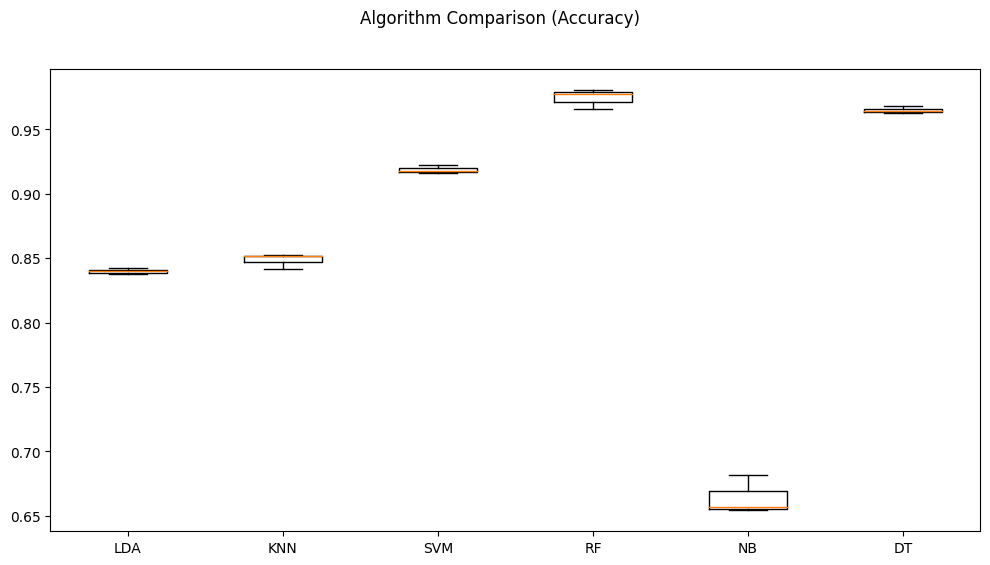

In [6]:
# boxplot algorithm comparison (accuracy)
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Algorithm Comparison (Accuracy)")
ax = fig.add_subplot(111)
plt.boxplot([result["test_accuracy"] for result in results])
ax.set_xticklabels(names)
plt.show()